In [2]:
import os
from projectaria_tools.core import data_provider
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
import numpy as np
from matplotlib import pyplot as plt

data_path = "/Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab/ops_lab_vrs"
vrsfile = os.path.join(data_path, "ops_lab.vrs")
open_traj_file = os.path.join(data_path, "mps_ops_lab_vrs/slam/open_loop_trajectory.csv")
closed_traj_file = os.path.join(data_path, "mps_ops_lab_vrs/slam/closed_loop_trajectory.csv")

provider = data_provider.create_vrs_data_provider(vrsfile)
assert provider is not None, "Cannot open file"

[ProgressLogger][INFO]: 2024-08-31 23:05:59: Opening /Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab/ops_lab_vrs/ops_lab.vrs...
[VRSIndexRecord][WARNING]: 12 record(s) not sorted properly. Sorting index.
[MultiRecordFileReader][DEBUG]: Opened file '/Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab/ops_lab_vrs/ops_lab.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 281-1/gps activated
[VrsDataProvider][INFO]: streamId 282-1/wps activated
[VrsDataProvider][INFO]: streamId 283-1/bluetooth activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO

### Random access data by index

In [ ]:
for stream_id in provider.get_all_streams():
  for i in range(0, provider.get_num_data(stream_id)):
    sensor_data =  provider.get_sensor_data_by_index(stream_id, i)

### [Get the camera-rgb image](https://facebookresearch.github.io/projectaria_tools/docs/data_utilities/core_code_snippets/image)

Stream ID:  214-1
Number of data:  1900
Image size:  1408 1408
Number of RGB images:  1900


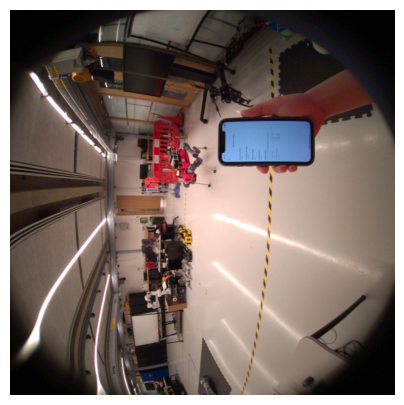

In [3]:
stream_id = provider.get_stream_id_from_label("camera-rgb")
num_data = provider.get_num_data(stream_id)
image_data =  provider.get_image_data_by_index(stream_id, 0)
pixel_frame = image_data[0].pixel_frame

print("Stream ID: ", stream_id)
print("Number of data: ", num_data)
print("Image size: ", pixel_frame.get_width(), pixel_frame.get_height())
print("Number of RGB images: ", provider.get_num_data(stream_id))

plt.figure(figsize=(5,5))
plt.imshow(image_data[0].to_numpy_array(), cmap="gray", vmin=0, vmax=255)
plt.axis('off')  # to hide the axis
plt.show()

### [Get calibration](https://facebookresearch.github.io/projectaria_tools/docs/data_utilities/core_code_snippets/calibration)

[SE3 and SO3 definition](https://facebookresearch.github.io/projectaria_tools/docs/data_utilities/core_code_snippets/calibration)

In [44]:
label = "camera-rgb"
cam_calib = device_calib.get_camera_calib(label)
print("Camera calibration: ", cam_calib)

Camera calibration:  CameraCalibration(label: camera-rgb, model name: Fisheye624, principal point: [711.465, 705.603], focal length: [611.177, 611.177], projection params: [611.177, 711.465, 705.603, 0.388213, -0.35362, -0.28504, 1.83316, -2.19092, 0.779653, 0.000397025, -9.34831e-05, 0.000127288, 0.000177712, 0.000224989, -5.78144e-05], image size (w,h): [1408, 1408], T_Device_Camera:(translation:[-0.00505346, -0.0121553, -0.00533367], quaternion(x,y,z,w):[0.331401, 0.0376227, 0.0351278, 0.942085]), serialNumber:0450577b730414734401100000000000)


### [Load MPS output](https://facebookresearch.github.io/projectaria_tools/docs/data_utilities/core_code_snippets/mps)

In [51]:
from projectaria_tools.core import data_provider
from projectaria_tools.core.mps.utils import get_nearest_pose
from projectaria_tools.core.stream_id import StreamId
import projectaria_tools.core.mps as mps

open_loop_traj = mps.read_open_loop_trajectory(open_traj_file)
closed_loop_traj = mps.read_closed_loop_trajectory(closed_traj_file)

# example: get transformation from this device to a world coordinate frame
for closed_loop_pose in closed_loop_traj:
	transform_world_device = closed_loop_pose.transform_world_device

# example: query to find the closest Timestamp device pose and move it to the Aria RGB camera pose
query_timestamp_ns = int(closed_loop_traj[1].tracking_timestamp.total_seconds() * 1e9)
pose_info = get_nearest_pose(closed_loop_traj, query_timestamp_ns)
if pose_info:
	T_world_device = pose_info.transform_world_device

	# Move this pose to the Project Aria RGB camera
	rgb_stream_id = StreamId("214-1")
	rgb_stream_label = provider.get_label_from_stream_id(rgb_stream_id)
	device_calibration = provider.get_device_calibration()
	rgb_camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)

	T_device_rgb_camera = rgb_camera_calibration.get_transform_device_camera()
	print(T_device_rgb_camera.to_matrix3x4())
	T_world_rgb_camera = T_world_device @ T_device_rgb_camera
	print(T_world_rgb_camera.to_matrix3x4())

Loaded #open loop trajectory poses records: 127164
Loaded #closed loop trajectory poses records: 125514
[[ 0.99470115 -0.04125033  0.09417026 -0.00505346]
 [ 0.09112311  0.77787852 -0.62177294 -0.01215532]
 [-0.04760468  0.62705935  0.77751551 -0.00533367]]
[[-2.97187495e-01  6.36709830e-01  7.11533685e-01  1.89507082e+00]
 [ 2.48774307e-01  7.71098303e-01 -5.86104727e-01 -1.17242413e+01]
 [-9.21841059e-01  2.82830395e-03 -3.87557820e-01  6.56799723e-01]]


### [Undistort image](https://facebookresearch.github.io/projectaria_tools/docs/data_utilities/advanced_code_snippets/image_utilities)
1. Load Image
2. Create the pinhole camera model and undistort the image
3. Rotate the image and update the camera model


Focal length:  [611.17747365 611.17747365]
Principal point:  [711.46452539 705.60316785]
Image size:  [1408 1408]
New Focal length:  [611.17747365 611.17747365]
New Principal point:  [703.5 703.5]
New Image size:  [1408 1408]
Rotated Focal length:  [611.17747365 611.17747365]
Rotated Principal point:  [703.5 703.5]
Rotated Image size:  [1408 1408]
[[ 0.99470115 -0.04125033  0.09417026 -0.00505346]
 [ 0.09112311  0.77787852 -0.62177294 -0.01215532]
 [-0.04760468  0.62705935  0.77751551 -0.00533367]]
[[ 0.99470115 -0.04125033  0.09417026 -0.00505346]
 [ 0.09112311  0.77787852 -0.62177294 -0.01215532]
 [-0.04760468  0.62705935  0.77751551 -0.00533367]]
[[ 0.04125033  0.99470115  0.09417026 -0.00505346]
 [-0.77787852  0.09112311 -0.62177294 -0.01215532]
 [-0.62705935 -0.04760468  0.77751551 -0.00533367]]


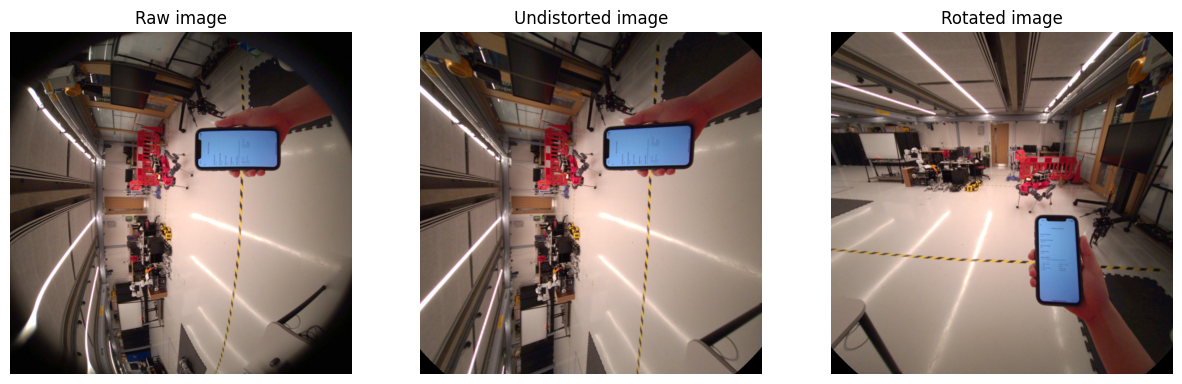

In [70]:
from projectaria_tools.core import data_provider, calibration
camera_label = "camera-rgb"
stream_id = provider.get_stream_id_from_label(camera_label)
calib = provider.get_device_calibration().get_camera_calib(camera_label)
focal_length = calib.get_focal_lengths()
principal_point = calib.get_principal_point()
image_size = calib.get_image_size()
print("Focal length: ", focal_length)
print("Principal point: ", principal_point)
print("Image size: ", image_size)

pinhole = calibration.get_linear_camera_calibration(
    image_size[0], image_size[1], focal_length[0], camera_label, calib.get_transform_device_camera())
new_focal_length = pinhole.get_focal_lengths()
new_principal_point = pinhole.get_principal_point()
new_image_size = pinhole.get_image_size()
print("New Focal length: ", new_focal_length)
print("New Principal point: ", new_principal_point)
print("New Image size: ", new_image_size)

raw_image = provider.get_image_data_by_index(stream_id, 0)[0].to_numpy_array()
undistorted_image = calibration.distort_by_calibration(raw_image, pinhole, calib)

rotated_image = np.rot90(undistorted_image, k=3)
pinhole_cw90 = calibration.rotate_camera_calib_cw90deg(pinhole)
rot_focal_length = pinhole_cw90.get_focal_lengths()
rot_principal_point = pinhole_cw90.get_principal_point()
rot_image_size = pinhole_cw90.get_image_size()
print("Rotated Focal length: ", rot_focal_length)
print("Rotated Principal point: ", rot_principal_point)
print("Rotated Image size: ", rot_image_size)

print(calib.get_transform_device_camera().to_matrix3x4())
print(pinhole.get_transform_device_camera().to_matrix3x4())
print(pinhole_cw90.get_transform_device_camera().to_matrix3x4())

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(raw_image, cmap='gray', vmin=0, vmax=255)
plt.title("Raw image")
plt.axis('off')  # to hide the axis
plt.subplot(1, 3, 2)
plt.imshow(undistorted_image, cmap='gray', vmin=0, vmax=255)
plt.title("Undistorted image")
plt.axis('off')  # to hide the axis
plt.subplot(1, 3, 3)
plt.imshow(rotated_image, cmap='gray', vmin=0, vmax=255)
plt.title("Rotated image")
plt.axis('off')  # to hide the axis
plt.show()
